A3C (Asynchronous Advantage Actor Critic) implementation with distributed 
Tensorflow & Python multiprocessing package. This is a discrete version with 
N-step targets (use maximum terms possible). The code is tested with Gym’s 
discrete action space environment, CartPole-v0 on Colab.

#Use tensorflow version 1.15.2

In [1]:
!pip install tensorflow==1.15.2

#Imports

In [0]:
from multiprocessing import Process

import time
import numpy as np
import matplotlib.pyplot as plt
import gym
import tensorflow as tf

#The actor-critic tensorflow graph

In [0]:
# tf Graph, ops
class ACNet(object):
    def __init__(self, scope, sess, globalAC=None):
        self.sess = sess
        OPT_A = tf.train.AdamOptimizer(actor_alpha, beta1=0.99, beta2=0.999, name='OPT_A')
        OPT_C = tf.train.AdamOptimizer(critic_alpha, beta1=0.99, beta2=0.999, name='OPT_C')          
        
        if scope == net_scope: # global
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, num_obvs], 'S')
                # create global net
                self.actor_params, self.critic_params = self._create_net(scope)[-2:] # only require params
                
        else: # local
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, num_obvs], 'S')
                self.a = tf.placeholder(tf.int32, [None, ], 'A')
                self.critic_target = tf.placeholder(tf.float32, [None, 1], 'critic_target')
                self.baselined_returns = tf.placeholder(tf.float32, [None, 1], 'baselined_returns') # for calculating advantage 
                # create local net
                self.action_prob, self.V, self.actor_params, self.critic_params = self._create_net(scope)
                    
                TD_err = tf.subtract(self.critic_target, self.V, name='TD_err')
                with tf.name_scope('actor_loss'):
                    log_prob = tf.reduce_sum(tf.log(self.action_prob + 1e-5) * tf.one_hot(self.a, num_actions, dtype=tf.float32), axis=1, keep_dims=True)
                    actor_component = log_prob * tf.stop_gradient(self.baselined_returns)
                    # entropy for exploration
                    entropy = -tf.reduce_sum(self.action_prob * tf.log(self.action_prob + 1e-5), axis=1, keep_dims=True)  # encourage exploration
                    self.actor_loss = tf.reduce_mean( -(ENTROPY_BETA * entropy + actor_component) )                                        
                with tf.name_scope('critic_loss'):
                    self.critic_loss = tf.reduce_mean(tf.square(TD_err))                      
                # accumulated gradients for local actor    
                with tf.name_scope('local_actor_grad'):                   
                    self.actor_zero_op, self.actor_accumu_op, self.actor_apply_op, actor_accum = self.accumu_grad(OPT_A, self.actor_loss, scope=scope + '/actor')
                # ********** accumulated gradients for local critic **********
                with tf.name_scope('local_critic_grad'):
                    self.critic_zero_op, self.critic_accumu_op, self.critic_apply_op, critic_accum = self.accumu_grad(OPT_C, self.critic_loss, scope=scope + '/critic')
                    
            with tf.name_scope('params'): # push/pull from local/worker perspective
                with tf.name_scope('push_to_global'):
                    self.push_actor_params = OPT_A.apply_gradients(zip(actor_accum, globalAC.actor_params))
                    self.push_critic_params = OPT_C.apply_gradients(zip(critic_accum, globalAC.critic_params))
                with tf.name_scope('pull_fr_global'):
                    self.pull_actor_params = [local_params.assign(global_params) for local_params, global_params in zip(self.actor_params, globalAC.actor_params)]
                    self.pull_critic_params = [local_params.assign(global_params) for local_params, global_params in zip(self.critic_params, globalAC.critic_params)]                    
                    
    def _create_net(self, scope):
        w_init = tf.glorot_uniform_initializer()
        with tf.variable_scope('actor'):
            hidden = tf.layers.dense(self.s, actor_hidden, tf.nn.relu6, kernel_initializer=w_init, name='hidden')
            action_prob = tf.layers.dense(hidden, num_actions, tf.nn.softmax, kernel_initializer=w_init, name='action_prob')        
        with tf.variable_scope('critic'):
            hidden = tf.layers.dense(self.s, critic_hidden, tf.nn.relu6, kernel_initializer=w_init, name='hidden')
            V = tf.layers.dense(hidden, 1, kernel_initializer=w_init, name='V')         
        actor_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
        critic_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')       
        return action_prob, V, actor_params, critic_params

    def accumu_grad(self, OPT, loss, scope):
        # retrieve trainable variables in scope of graph
        #tvs = tf.trainable_variables(scope=scope + '/actor')
        tvs = tf.trainable_variables(scope=scope)
        # ceate a list of variables with the same shape as the trainable
        accumu = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in tvs]
        zero_op = [tv.assign(tf.zeros_like(tv)) for tv in accumu] # initialized with 0s
        gvs = OPT.compute_gradients(loss, tvs) # obtain list of gradients & variables
        #gvs = [(tf.where( tf.is_nan(grad), tf.zeros_like(grad), grad ), var) for grad, var in gvs]
        # adds to each element from the list you initialized earlier with zeros its gradient 
        # accumu and gvs are in same shape, index 0 is grads, index 1 is vars
        accumu_op = [accumu[i].assign_add(gv[0]) for i, gv in enumerate(gvs)]
        apply_op = OPT.apply_gradients([(accumu[i], gv[1]) for i, gv in enumerate(gvs)]) # apply grads
        return zero_op, accumu_op, apply_op, accumu      
      
    def push_global_actor(self, feed_dict): 
        SESS = self.sess
        SESS.run([self.push_actor_params], feed_dict)  

    def push_global_critic(self, feed_dict):  
        SESS = self.sess
        SESS.run([self.push_critic_params], feed_dict)         
        
    def pull_global(self):  
        SESS = self.sess
        SESS.run([self.pull_actor_params, self.pull_critic_params])

    def choose_action(self, s):  
        SESS = self.sess
        prob_weights = SESS.run(self.action_prob, feed_dict={self.s: s[None, :]})
        action = np.random.choice(range(prob_weights.shape[1]), p=prob_weights.ravel()) 
        return action             
        
    def init_grad_storage_actor(self):
        SESS = self.sess
        SESS.run(self.actor_zero_op)
        
    def accumu_grad_actor(self, feed_dict):
        SESS = self.sess
        SESS.run([self.actor_accumu_op], feed_dict)          
    
    def apply_accumu_grad_actor(self, feed_dict):
        SESS = self.sess
        SESS.run([self.actor_apply_op], feed_dict)   
        
    def init_grad_storage_critic(self):
        SESS = self.sess
        SESS.run(self.critic_zero_op)
        
    def accumu_grad_critic(self, feed_dict):
        SESS = self.sess
        SESS.run([self.critic_accumu_op], feed_dict)          
    
    def apply_accumu_grad_critic(self, feed_dict):
        SESS = self.sess
        SESS.run([self.critic_apply_op], feed_dict)  

#Worker class

In [0]:
class Worker(object): # local only
    def __init__(self, name, globalAC, GLOBAL_EP, GLOBAL_RUNNING_R, sess):
        self.env = gym.make(game)
        self.name = name
        self.AC = ACNet(name, sess, globalAC)
        self.sess = sess
        self.GLOBAL_EP = GLOBAL_EP
        self.GLOBAL_RUNNING_R = GLOBAL_RUNNING_R
        
    def work(self):
        #global GLOBAL_EP, GLOBAL_RUNNING_R
        T = 0
        t = 0
        SESS = self.sess
        GLOBAL_EP = self.GLOBAL_EP
        GLOBAL_RUNNING_R = self.GLOBAL_RUNNING_R
        
        #while not COORD.should_stop() and GLOBAL_EP < max_global_episodes:
        while SESS.run(GLOBAL_EP) < max_global_episodes:
            s = self.env.reset()
            ep_r = 0 # reward per episode
            done = False
            buffer_s, buffer_a, buffer_r, buffer_done = [], [], [], []
            self.AC.pull_global()
            while not done:
                a = self.AC.choose_action(s)
                s_, r, done, info = self.env.step(a)
                ep_r += r
                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append(r)
                buffer_done.append(done)                
                s = s_
                t += 1
            
            # if statement will always be done in this case... 
            # possible future modification
            if done:
                V_s = 0   
            else:
                V_s = SESS.run(self.AC.V, {self.AC.s: s[None, :]})[0, 0] # takes in just one s, not a batch.
            
            # critic related
            critic_target = self.discount_rewards(buffer_r, GAMMA, V_s)
            
            buffer_s, buffer_a, critic_target = np.vstack(buffer_s), np.array(buffer_a), np.vstack(critic_target)
            feed_dict = {self.AC.s: buffer_s, self.AC.critic_target: critic_target}                         
            self.AC.accumu_grad_critic(feed_dict) # accumulating gradients for local critic  
            self.AC.apply_accumu_grad_critic(feed_dict) 
            
            baseline = SESS.run(self.AC.V, {self.AC.s: buffer_s}) # Value function
            epr = np.vstack(buffer_r).astype(np.float32)
            #V_s = SESS.run(self.AC.V, {self.AC.s: s[None, :]})[0, 0] # takes in just one s, not a batch.
            #n_step_targets = self.n_step_targets_missing(epr, baseline, GAMMA, N_step) # Q values
            n_step_targets = self.n_step_targets_max(epr, baseline, V_s, GAMMA, N_step) # Q values
            # Advantage function
            baselined_returns = n_step_targets - baseline

            feed_dict = {self.AC.s: buffer_s, self.AC.a: buffer_a, self.AC.critic_target: critic_target, self.AC.baselined_returns: baselined_returns}            
            self.AC.accumu_grad_actor(feed_dict) # accumulating gradients for local actor  
            
            # update
            self.AC.push_global_actor(feed_dict)                
            self.AC.push_global_critic(feed_dict)
            buffer_s, buffer_a, buffer_r, buffer_done = [], [], [], []
            self.AC.pull_global()
              
            if T % delay_rate == 0: # delay clearing of local gradients storage to reduce noise
                # apply to local
                self.AC.init_grad_storage_actor() # initialize storage for accumulated gradients.
                self.AC.init_grad_storage_critic() 
                
            #GLOBAL_EP += 1                   
            SESS.run(GLOBAL_EP.assign_add(1.0))
            #GLOBAL_RUNNING_R.append(ep_r) # for display
            qe = GLOBAL_RUNNING_R.enqueue(ep_r)
            SESS.run(qe)            
            
    def discount_rewards(self, r, gamma, running_add):
      """Take 1D float array of rewards and compute discounted reward """
      discounted_r = np.zeros_like(r)
      #running_add = 0
      for t in reversed(range(len(r))):
          running_add = running_add * gamma + r[t]
          discounted_r[t] = running_add
      return discounted_r 
  
    # As n increase, variance increase.
    # Create a function that returns an array of n-step targets, one for each timestep:
    # target[t] = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... + \gamma^n V(s_{t+n})
    # Where r_t is given by episode reward (epr) and V(s_n) is given by the baselines.
    
    def n_step_targets_missing(self, epr, baselines, gamma, N):
      targets = np.zeros_like(epr)    
      if N > epr.size:
        N = epr.size
      for t in range(epr.size):    
        for n in range(N):
          if t+n == epr.size:            
            break # missing terms treated as 0
          if n == N-1: # last term
            targets[t] += (gamma**n) * baselines[t+n]
          else:
            targets[t] += (gamma**n) * epr[t+n] 
      return targets  
    
    def n_step_targets_max(self, epr, baselines, v_s_, gamma, N):
      targets = np.zeros_like(epr)    
      if N > epr.size:
        N = epr.size
      for t in range(epr.size):  
        #print("t=", t)
        for n in range(N):
          #print("n=", n)
          if t+n == epr.size:            
            targets[t] += (gamma**n) * v_s_ # use max steps available
            break 
          if n == N-1: # last term
            targets[t] += (gamma**n) * baselines[t+n]
          else:
            targets[t] += (gamma**n) * epr[t+n] 
      return targets     

#Global variables & hyperparameters

In [0]:
game = 'CartPole-v0'
#env = gym.make(game).unwrapped
env = gym.make(game)

num_obvs = env.observation_space.shape[0]
num_actions = env.action_space.n

net_scope = 'global'
max_global_episodes = 500#5 #500
delay_rate = 4000 # T steps

GAMMA = 0.999 #0.99
ENTROPY_BETA = 0.1 #0.01
actor_alpha = 0.01   
critic_alpha = 0.01   
actor_hidden = 64#4 #128 #200
critic_hidden = 64#4 #128 #200
N_step = 15

#Setup cluster

In [0]:
cluster = tf.train.ClusterSpec({
    "worker": ["localhost:2223",
               "localhost:2224"
              ],
    "ps": ["localhost:2225"]
})

def parameter_server():
    #tf.reset_default_graph()
    
    server = tf.train.Server(cluster,
                             job_name="ps",
                             task_index=0)
    sess = tf.Session(target=server.target)        
    
    with tf.device("/job:ps/task:0"):
        GLOBAL_AC = ACNet(net_scope, sess, globalAC=None) # only need its params
        GLOBAL_EP = tf.Variable(0.0, name='GLOBAL_EP') # num of global episodes   
        # a queue of ep_r
        GLOBAL_RUNNING_R = tf.FIFOQueue(max_global_episodes, tf.float32, shared_name="GLOBAL_RUNNING_R")        
    
    print("Parameter server: waiting for cluster connection...")
    sess.run(tf.report_uninitialized_variables())
    print("Parameter server: cluster ready!")
    
    print("Parameter server: initializing variables...")
    sess.run(tf.global_variables_initializer())
    print("Parameter server: variables initialized")
    
    while True:
        time.sleep(1.0)
        #print("ps 1 GLOBAL_EP: ", sess.run(GLOBAL_EP))
        #print("ps 1 GLOBAL_RUNNING_R.size(): ", sess.run(GLOBAL_RUNNING_R.size()))  
        if sess.run(GLOBAL_RUNNING_R.size()) >= max_global_episodes: # GLOBAL_EP starts from 0, hence +1 to max_global_episodes          
            time.sleep(5.0)
            #print("ps 2 GLOBAL_RUNNING_R.size(): ", sess.run(GLOBAL_RUNNING_R.size()))  
            GLOBAL_RUNNING_R_list = []
            for j in range(sess.run(GLOBAL_RUNNING_R.size())):
                ep_r = sess.run(GLOBAL_RUNNING_R.dequeue())
                GLOBAL_RUNNING_R_list.append(ep_r) # for display
            break
              
    # display
    plt.plot(np.arange(len(GLOBAL_RUNNING_R_list)), GLOBAL_RUNNING_R_list)
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.show()  

    #print("Parameter server: blocking...")
    #server.join() # currently blocks forever    
    print("Parameter server: ended...")

def worker(worker_n): 
    #tf.reset_default_graph()
    
    server = tf.train.Server(cluster,
                             job_name="worker",
                             task_index=worker_n)
    sess = tf.Session(target=server.target)  
  
    with tf.device("/job:ps/task:0"):
        GLOBAL_AC = ACNet(net_scope, sess, globalAC=None) # only need its params
        GLOBAL_EP = tf.Variable(0.0, name='GLOBAL_EP') # num of global episodes
        # a queue of ep_r
        GLOBAL_RUNNING_R = tf.FIFOQueue(max_global_episodes, tf.float32, shared_name="GLOBAL_RUNNING_R")   
    """
    with tf.device(tf.train.replica_device_setter(
                        worker_device='/job:worker/task:' + str(worker_n),
                        cluster=cluster)):
    """                        
    print("Worker %d: waiting for cluster connection..." % worker_n)
    sess.run(tf.report_uninitialized_variables())
    print("Worker %d: cluster ready!" % worker_n)
    
    #while sess.run(tf.report_uninitialized_variables()):
    while (sess.run(tf.report_uninitialized_variables())).any(): # ********** .any() .all() **********
        print("Worker %d: waiting for variable initialization..." % worker_n)
        time.sleep(1.0)
    print("Worker %d: variables initialized" % worker_n)
    
    w = Worker(str(worker_n), GLOBAL_AC, GLOBAL_EP, GLOBAL_RUNNING_R, sess) 
    print("Worker %d: created" % worker_n)
    
    sess.run(tf.global_variables_initializer()) # got to initialize after Worker creation
    w.work()
    print("Worker %d: w.work()" % worker_n)
          
    #print("Worker %d: blocking..." % worker_n)
    server.join() # currently blocks forever
    print("Worker %d: ended..." % worker_n)  

#Setup processes, rollout & train

Instructions for updating:
Use keras.layers.Dense instead.WARNING:tensorflow:From <ipython-input-3-dec5e8c17b0c>:49: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Please use `layer.__call__` method instead.WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/layers/core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.

Worker 1: waiting for cluster connection...
Parameter server: waiting for cluster connection...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Worker 0: waiting for cluster connection.

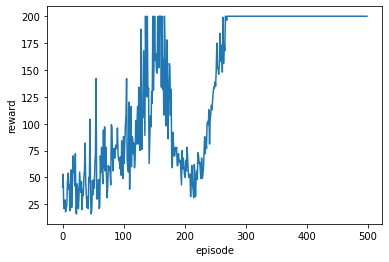

Parameter server: ended...
All done.
--- 166.8326187133789 seconds ---


In [7]:
start_time = time.time()

ps_proc = Process(target=parameter_server, daemon=True)
w1_proc = Process(target=worker, args=(0, ), daemon=True)
w2_proc = Process(target=worker, args=(1, ), daemon=True)

ps_proc.start()
w1_proc.start()
w2_proc.start()

# if not join, parent will terminate before children 
# & children will terminate as well cuz children are daemon
ps_proc.join() 
#w1_proc.join()
#w2_proc.join() 
    
for proc in [w1_proc, w2_proc, ps_proc]:
    proc.terminate() # only way to kill server is to kill it's process
        
print('All done.')     

print("--- %s seconds ---" % (time.time() - start_time))    